In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/MOBA_scRNAseq/outs_S2"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1326 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [4]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

AnnData object with n_obs × n_vars = 1326 × 5572
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [5]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.947
Zero inflation of aggregated data: 0.856


### Filter cells

--> filter based on mean absolute standard deviation

In [6]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
# print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

outlier
False    1255
True       71
Name: count, dtype: int64
Total number of cells: 1326
Number of cells after filtering: 1255


AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

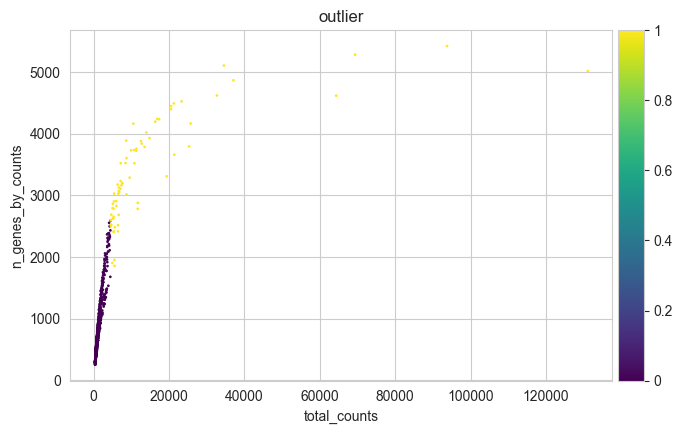

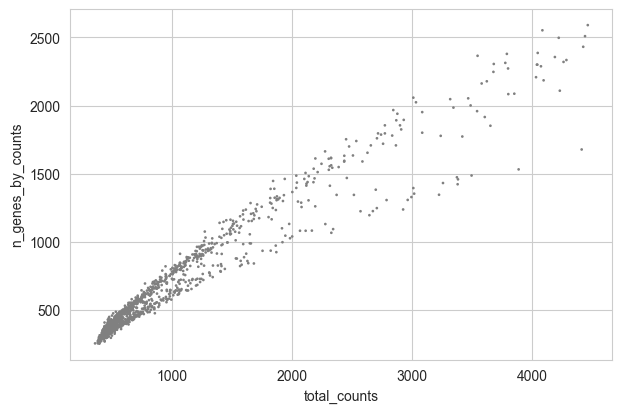

In [7]:
sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis")
plt.show()
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [8]:
data_gene.layers["counts"] = data_gene.X.copy().toarray()

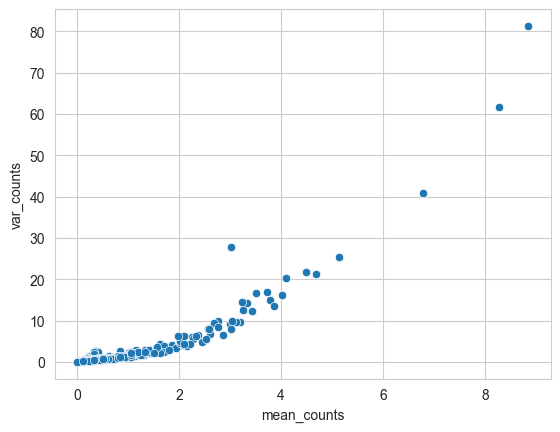

In [9]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.show()

## Estimate negative binomial parameters for each gene

In [10]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts")

Fitting feature 100/5540
Fitting feature 200/5540
Fitting feature 300/5540
Fitting feature 400/5540
Fitting feature 500/5540
Fitting feature 600/5540
Fitting feature 700/5540
Fitting feature 800/5540
Fitting feature 900/5540
Fitting feature 1000/5540
Fitting feature 1100/5540
Fitting feature 1200/5540
Fitting feature 1300/5540
Fitting feature 1400/5540
Fitting feature 1500/5540
Fitting feature 1600/5540
Fitting feature 1700/5540
Fitting feature 1800/5540
Fitting feature 1900/5540
Fitting feature 2000/5540
Fitting feature 2100/5540
Fitting feature 2200/5540
Fitting feature 2300/5540
Fitting feature 2400/5540
Fitting feature 2500/5540
Fitting feature 2600/5540
Fitting feature 2700/5540
Fitting feature 2800/5540
Fitting feature 2900/5540
Fitting feature 3000/5540
Fitting feature 3100/5540
Fitting feature 3200/5540
Fitting feature 3300/5540
Fitting feature 3400/5540
Fitting feature 3500/5540
Fitting feature 3600/5540
Fitting feature 3700/5540
Fitting feature 3800/5540
Fitting feature 3900/

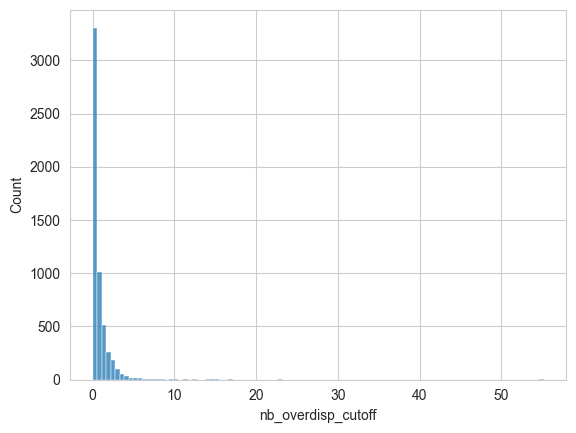

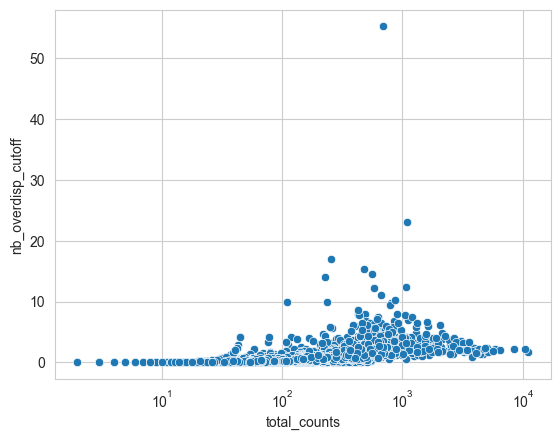

In [11]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="total_counts")
g.set(xscale="log")
plt.show()

In [12]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [13]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
data_gene.X = np.log(data_gene.X + np.array(data_gene.var["nb_overdisp_cutoff"] / 4))
data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
sc.tl.pca(data_gene, svd_solver='arpack')

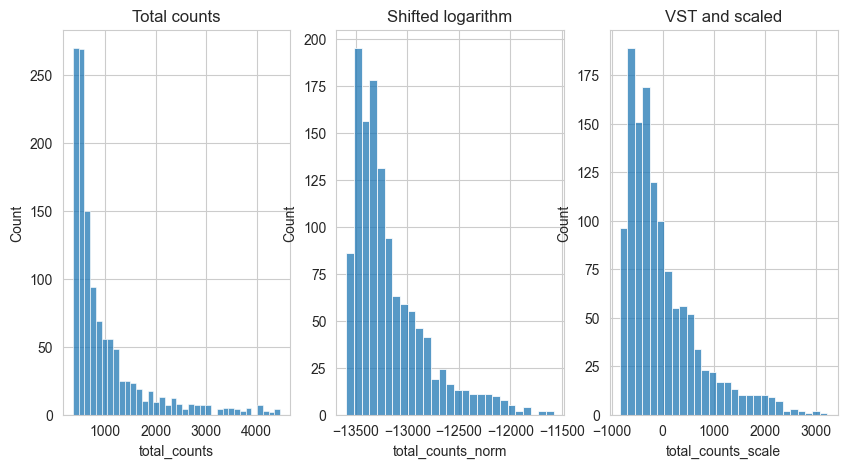

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.show()

## Count-splitting into train and test data

In [15]:
data_train, data_test = cs.countsplit_adata(data_gene, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9)


In [16]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
data_train.X = np.log(data_train.X + np.array(data_train.var["nb_overdisp_cutoff"] / 4))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.X = np.log(data_test.X + np.array(data_test.var["nb_overdisp_cutoff"] / 4))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

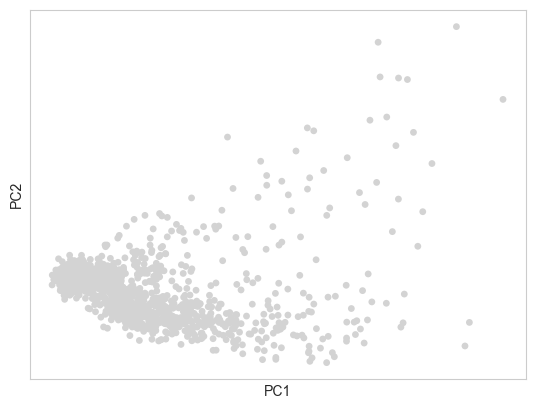

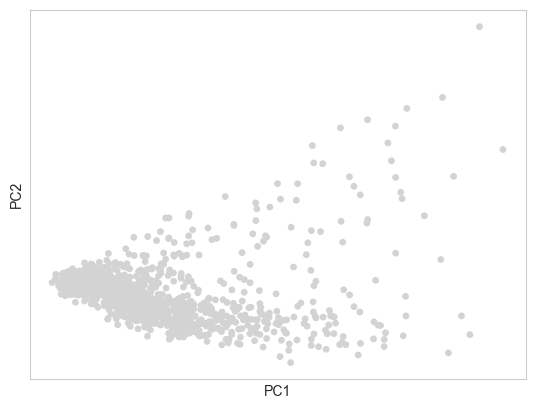

In [17]:
sc.pl.pca(data_train)
plt.show()

sc.pl.pca(data_test)
plt.show()

### Principal component selection

In [18]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:3


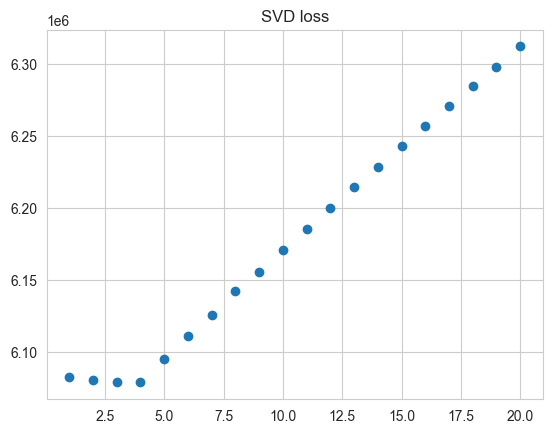

3 PCs seems to be the optimum


In [19]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.show()

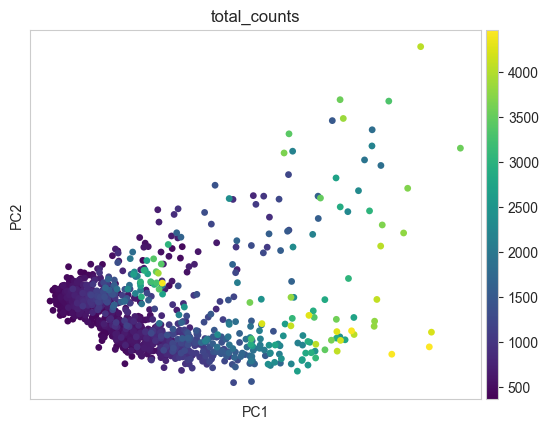

In [20]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis")
plt.show()

In [21]:
print(data_gene)

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'


## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [39]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
min_dists = [0.05, 0.1, 0.3, 0.5]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, embedding_method="UMAP", similarity_percent=0.5, save_path="S2_filtered_scdeed")

calculating (10, 0.05) - run 1/56
calculating (10, 0.1) - run 2/56
calculating (10, 0.3) - run 3/56
calculating (10, 0.5) - run 4/56
calculating (15, 0.05) - run 5/56
calculating (15, 0.1) - run 6/56
calculating (15, 0.3) - run 7/56
calculating (15, 0.5) - run 8/56
calculating (20, 0.05) - run 9/56
calculating (20, 0.1) - run 10/56
calculating (20, 0.3) - run 11/56
calculating (20, 0.5) - run 12/56
calculating (25, 0.05) - run 13/56
calculating (25, 0.1) - run 14/56
calculating (25, 0.3) - run 15/56
calculating (25, 0.5) - run 16/56
calculating (30, 0.05) - run 17/56
calculating (30, 0.1) - run 18/56
calculating (30, 0.3) - run 19/56
calculating (30, 0.5) - run 20/56
calculating (35, 0.05) - run 21/56
calculating (35, 0.1) - run 22/56
calculating (35, 0.3) - run 23/56
calculating (35, 0.5) - run 24/56
calculating (40, 0.05) - run 25/56
calculating (40, 0.1) - run 26/56
calculating (40, 0.3) - run 27/56
calculating (40, 0.5) - run 28/56
calculating (45, 0.05) - run 29/56
calculating (45

Optimal number of neighbors: 20
Optimal min_dist: 0.05


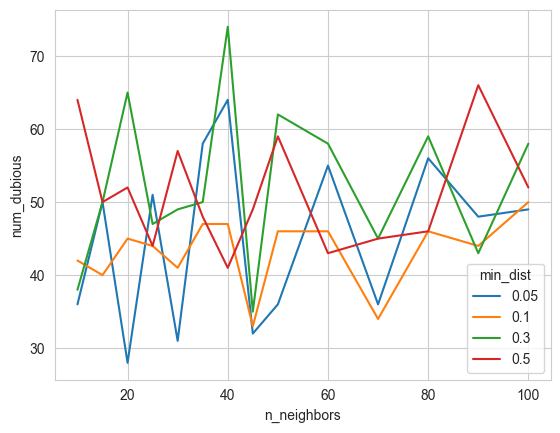

In [40]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.show()

In [41]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


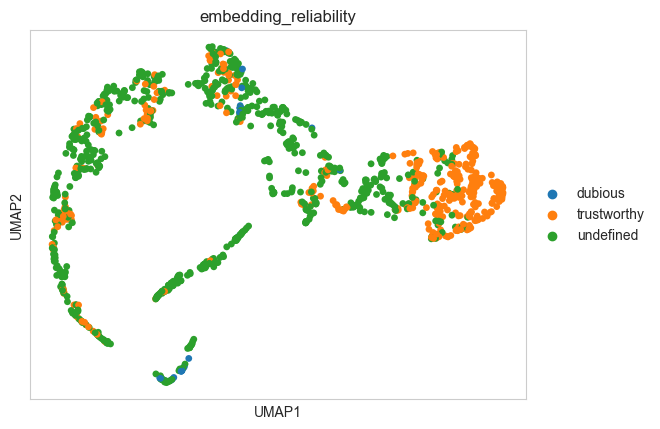

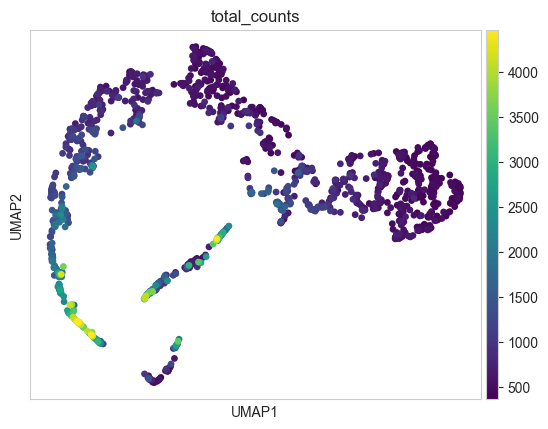

In [42]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [43]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [44]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

# Rotate test UMAP for better comparability
theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

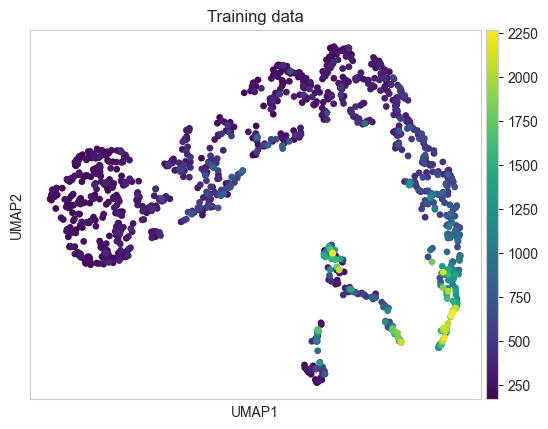

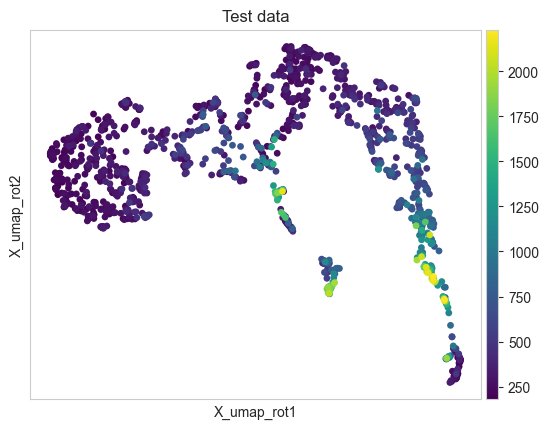

In [45]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [46]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

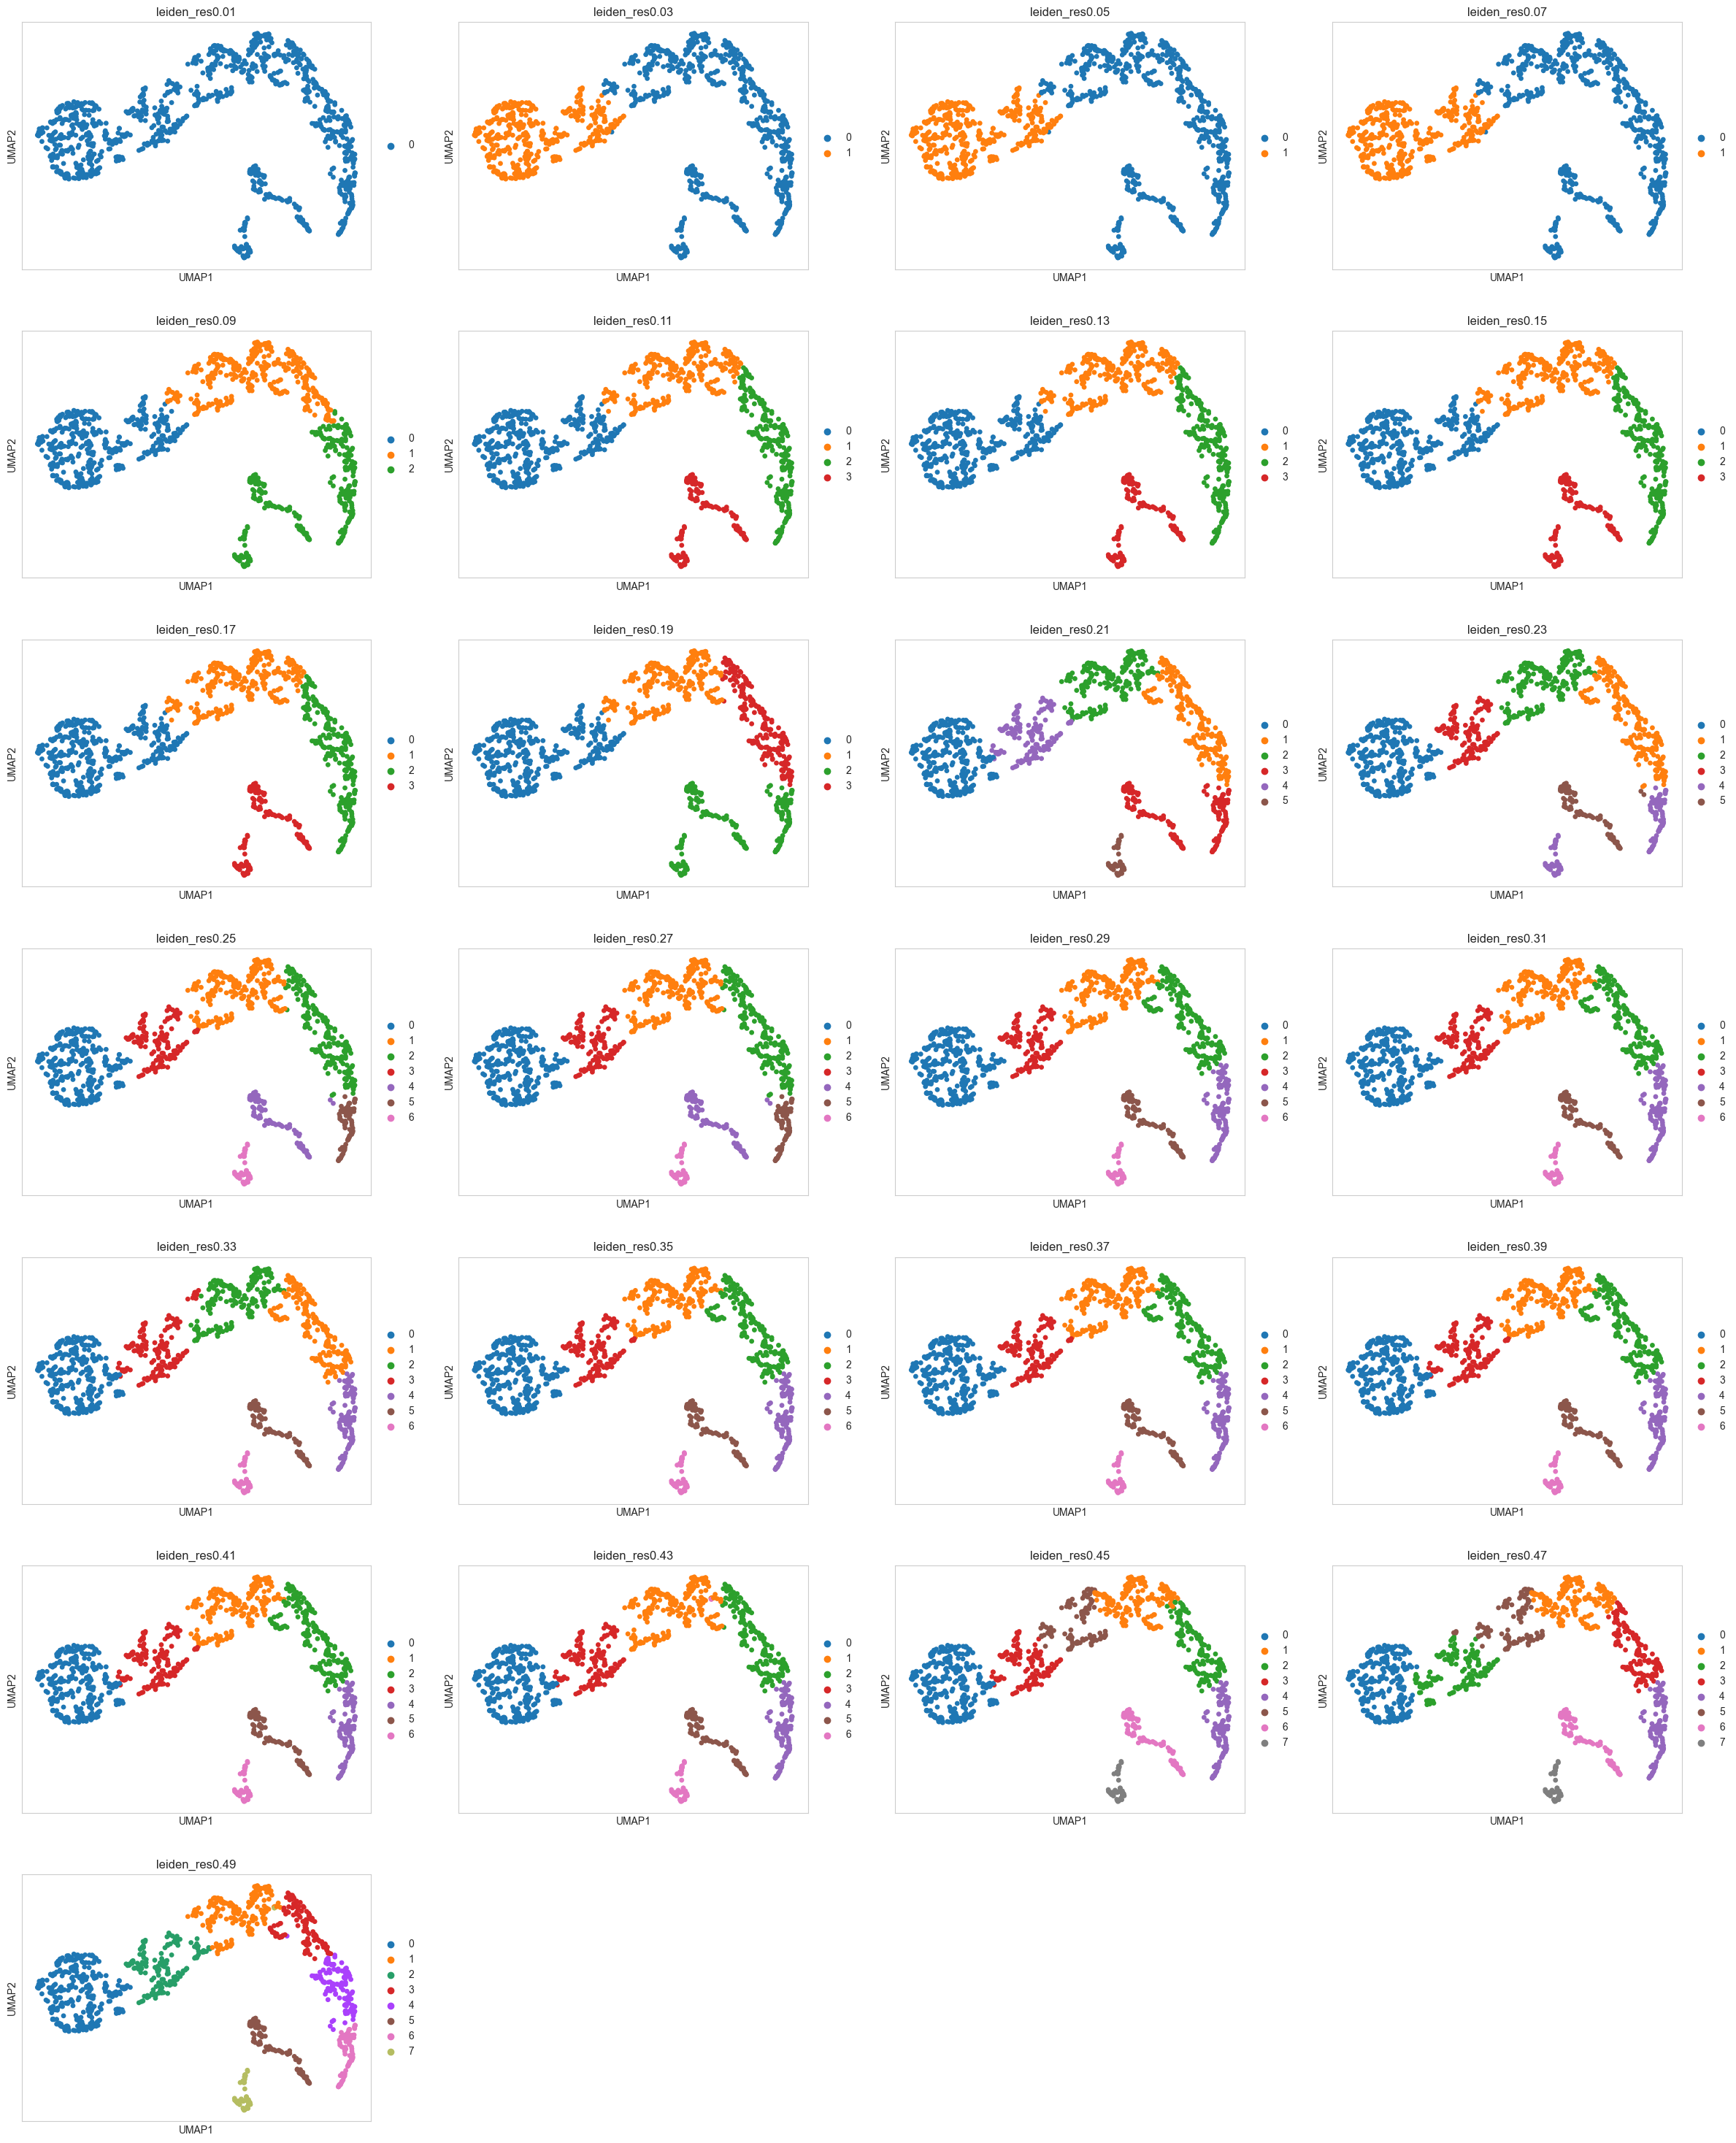

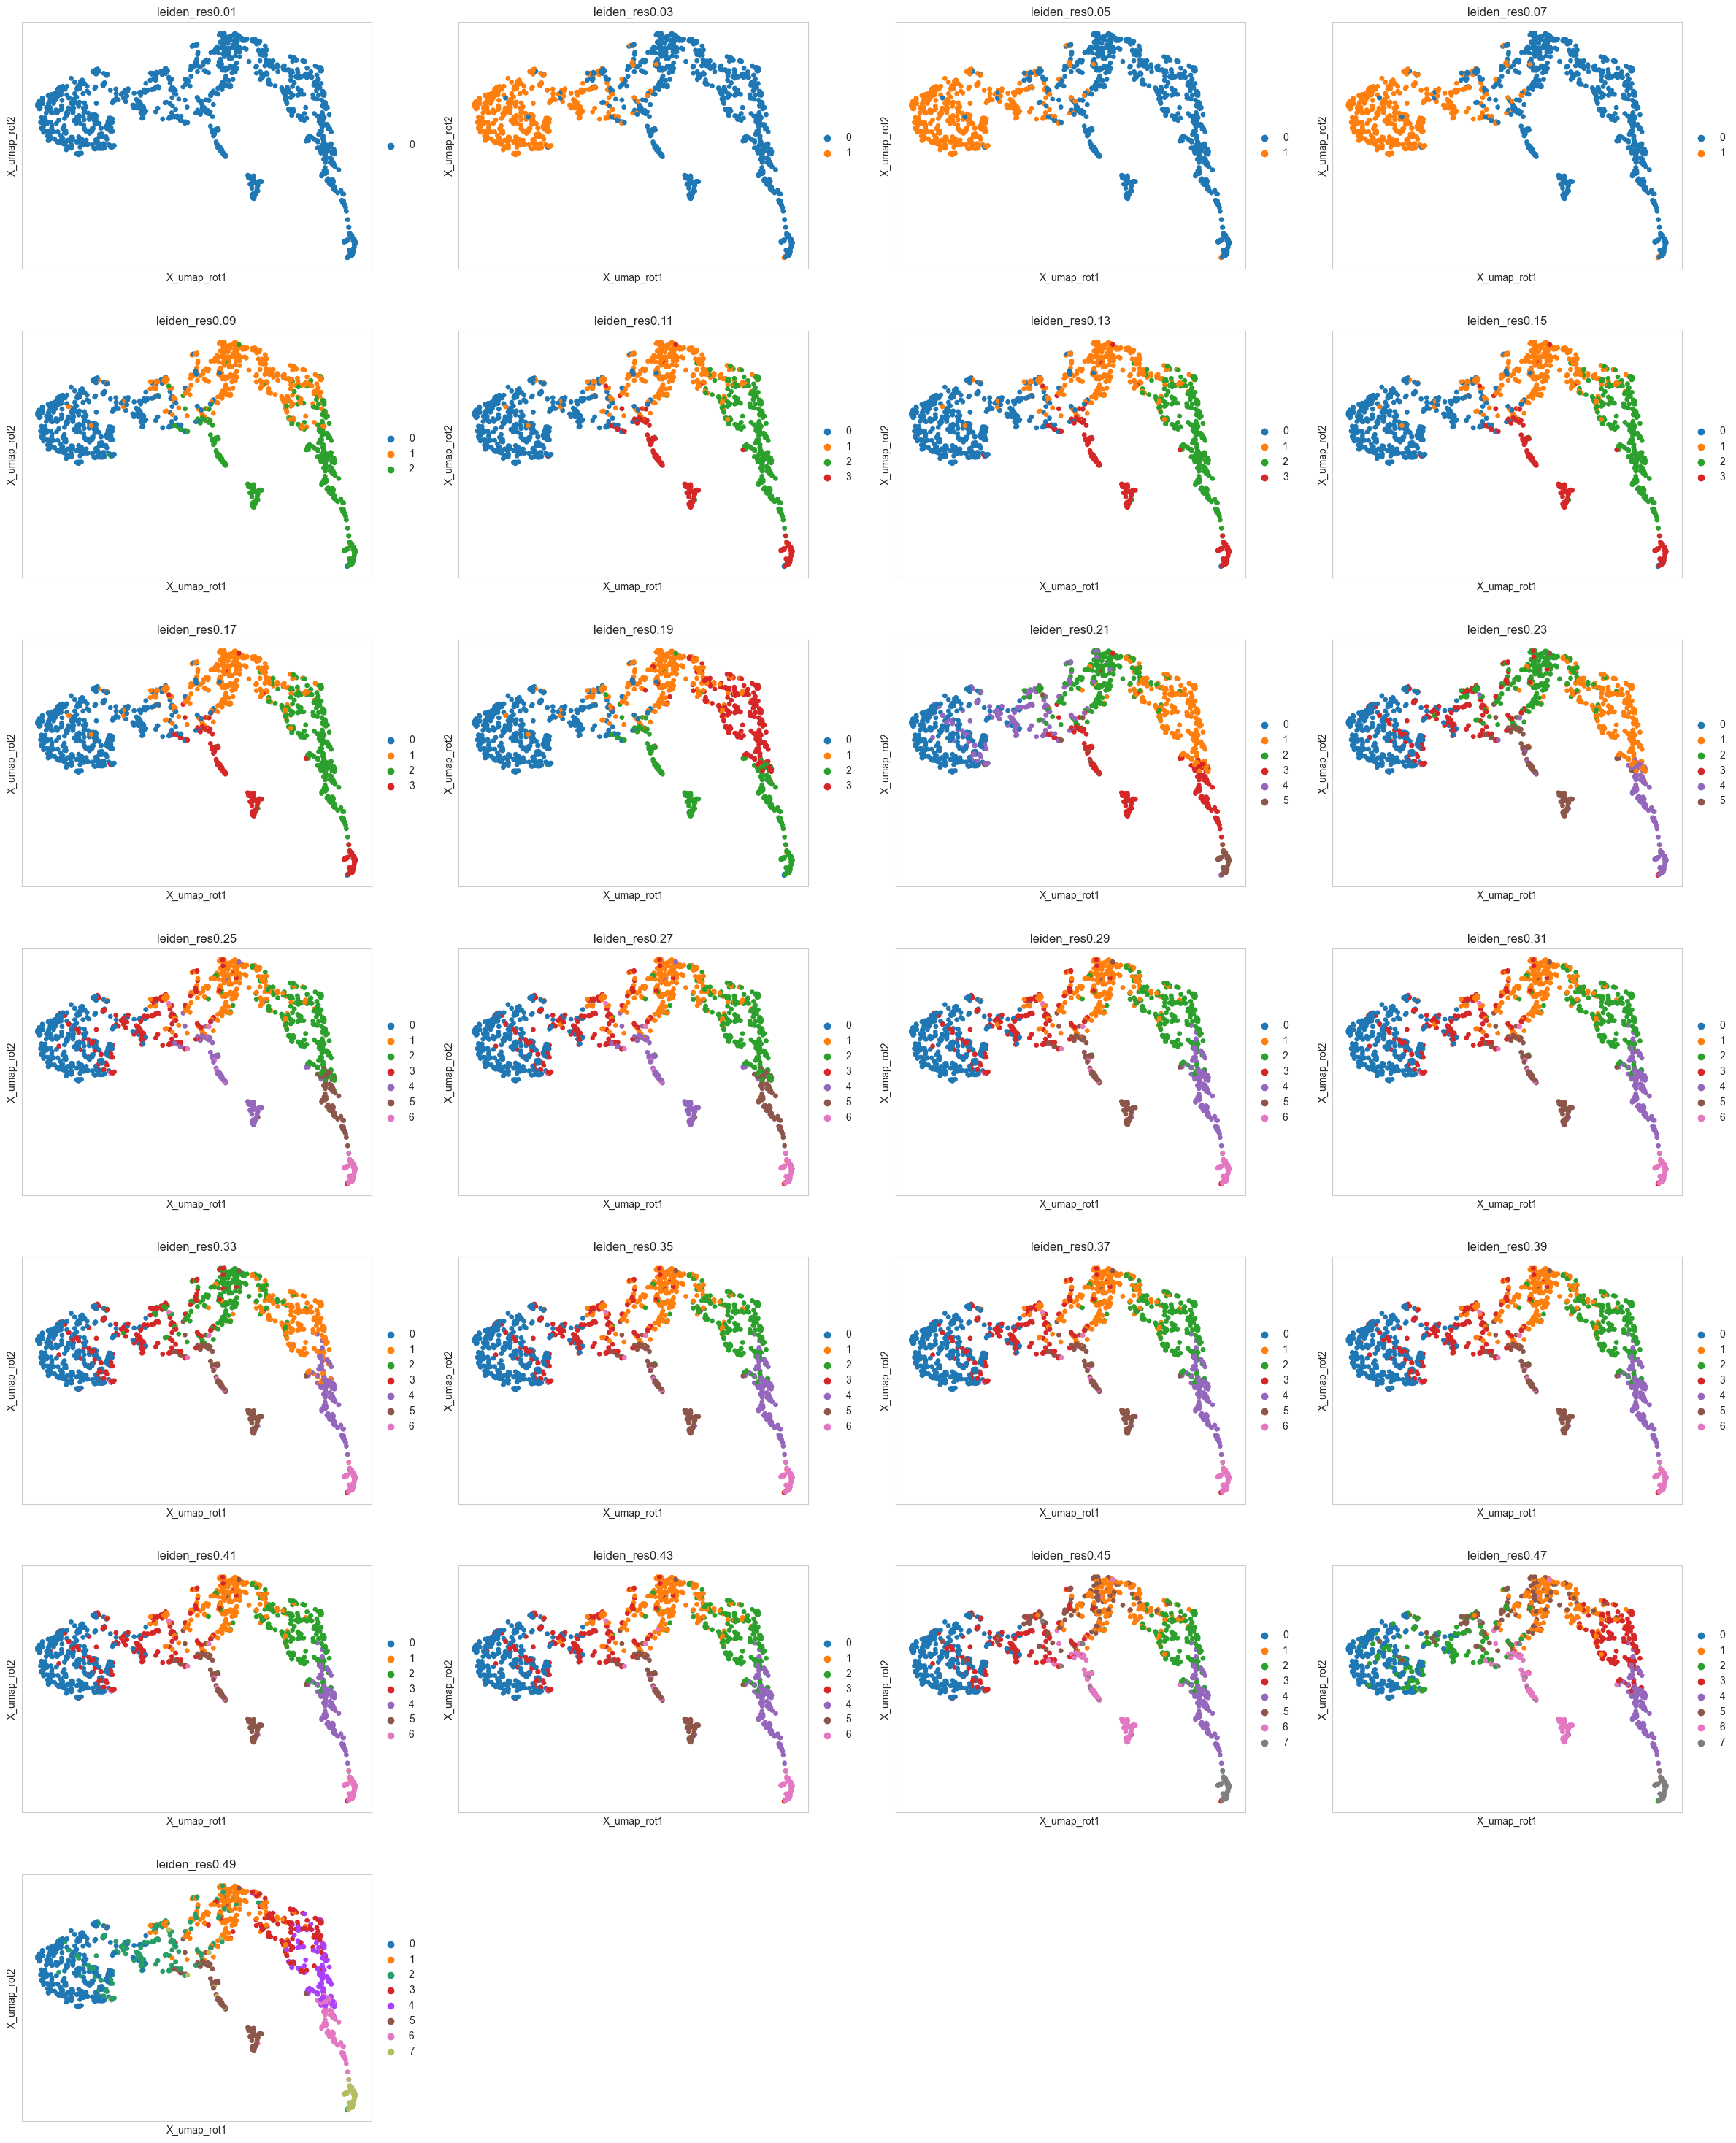

In [47]:
sc.pl.umap(data_train, color=[f"leiden_res{resolution}" for resolution in resolutions])
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color=[f"leiden_res{resolution}" for resolution in resolutions])
plt.show()

Modularities

In [48]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 2 - Train: 0.473 - Test: 0.449 - Random: 0.249
resolution: 0.05 - clusters: 2 - Train: 0.463 - Test: 0.438 - Random: 0.239
resolution: 0.07 - clusters: 2 - Train: 0.452 - Test: 0.428 - Random: 0.228
resolution: 0.09 - clusters: 3 - Train: 0.448 - Test: 0.399 - Random: 0.137
resolution: 0.11 - clusters: 4 - Train: 0.442 - Test: 0.393 - Random: 0.11
resolution: 0.13 - clusters: 4 - Train: 0.437 - Test: 0.387 - Random: 0.101
resolution: 0.15 - clusters: 4 - Train: 0.431 - Test: 0.381 - Random: 0.098
resolution: 0.17 - clusters: 4 - Train: 0.426 - Test: 0.376 - Random: 0.093
resolution: 0.19 - clusters: 4 - Train: 0.421 - Test: 0.358 - Random: 0.082
resolution: 0.21 - clusters: 6 - Train: 0.418 - Test: 0.328 - Random: 0.055
resolution: 0.23 - clusters: 6 - Train: 0.415 - Test: 0.326 - Random: 0.051
resolution: 0.25 - clusters: 7 - Train: 0.412 - Test: 0.321 - Random: 0.045
resolution: 0.27

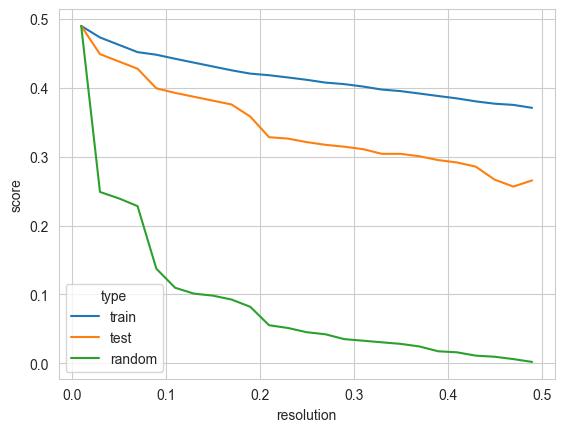

In [49]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.show()

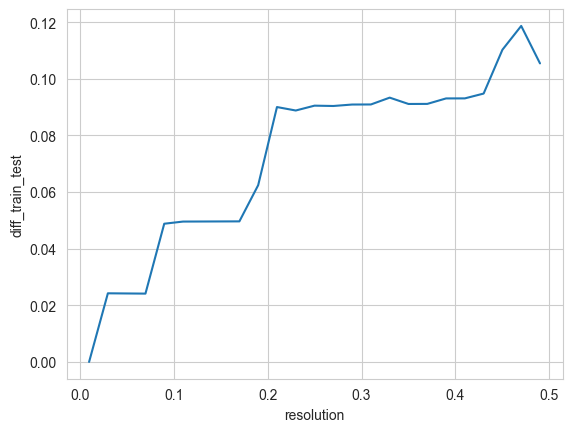

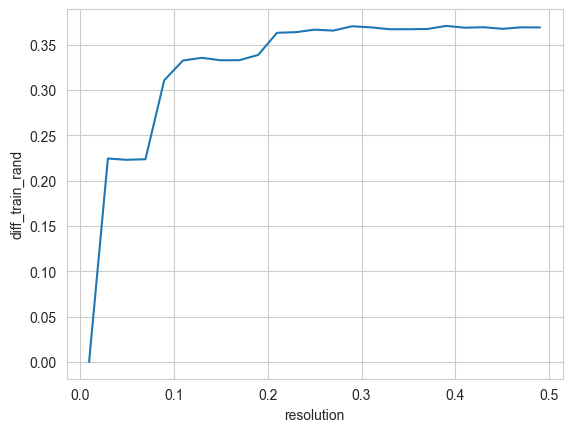

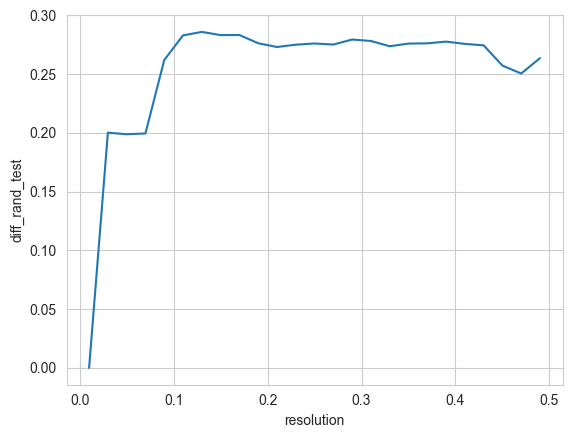

In [50]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_train_test")
plt.show()
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_train_rand")
plt.show()
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.show()

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [51]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

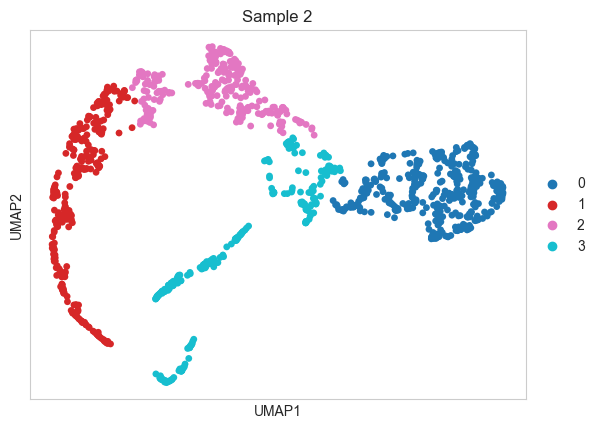

In [52]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 2")
plt.show()

In [53]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")

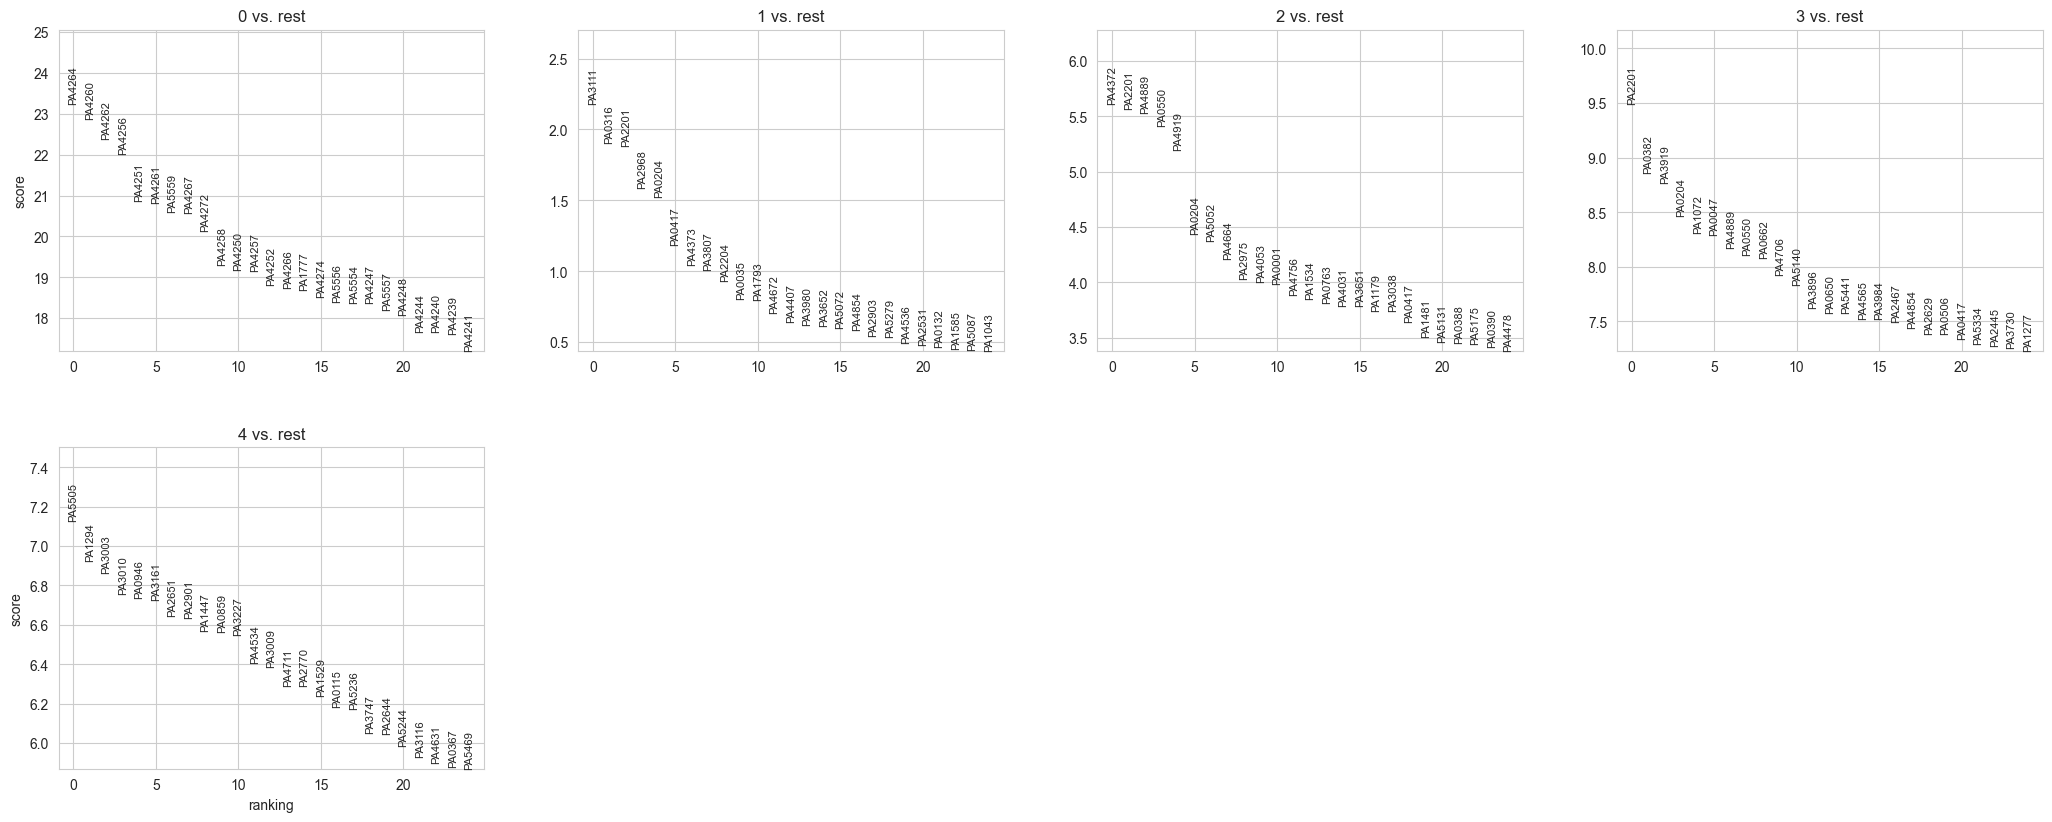

In [37]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

In [38]:
top_genes_5 = [x[5] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(top_genes_5[:25])

IndexError: invalid index (5)

In [ ]:
sc.pl.umap(data_gene, color=top_genes_5[:25], palette="tab20", cmap="viridis")